# Temat testów:
### Czy istnieje istotna statystycznie różnica w czasie odpowiedzi w zależności od trudności zadania? (grupy: wszystkie grafiki, grafiki A, grafiki B, grafiki 1,2,3)

In [79]:
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
import pandas as pd
from scipy.stats import shapiro, f_oneway, levene, kruskal
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
df_corr = pd.read_csv('/Users/martasolarz/Studies/Thesis/data/correctness.csv',
    usecols=['ID', '1a_trud', '1b_trud', '2a_trud', '2b_trud', '3a_trud', '3b_trud']
)

df_corr = df_corr[df_corr.ID != 6] # odrzucony uczestnik ze względu na metryki eye trackingowe

df_time =  pd.read_csv('/Users/martasolarz/Studies/Thesis/data/metrics/times.csv',
    usecols=['ID', 'Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b']
)

df_merge = df_corr.merge(df_time, on='ID')
df_merge.head()

,ID,1a_trud,1b_trud,2a_trud,2b_trud,3a_trud,3b_trud,Duration_1a,Duration_1b,Duration_2a,Duration_2b,Duration_3a,Duration_3b
0,1,3,1,4,3,4,4,28015,15516,54481,58697,56314,63897
1,2,1,2,3,1,2,4,66230,88463,42248,85329,47948,129427
2,3,2,1,3,1,1,1,68830,83963,45165,32732,8000,61197
3,4,3,2,2,1,3,5,46048,78446,12449,37715,60980,101795
4,5,4,2,3,2,3,3,67980,27582,55931,22132,34898,62930


Funkcje:

In [81]:
def prepate_set(list_of_cols_czas, list_of_cols_trud):
    new_row_czas = list_of_cols_czas[0]
    for i in list_of_cols_czas[1:]:
        new_row_czas = pd.concat([new_row_czas, i], ignore_index=True)

    new_row_trud = list_of_cols_trud[0]
    for i in list_of_cols_trud[1:]:
        new_row_trud = pd.concat([new_row_trud, i], ignore_index=True)

    return pd.DataFrame({'trudnosc': new_row_trud, 'czas': new_row_czas})

In [82]:
def is_gaussian(data, alpha):
    stats, p = shapiro(data)
    print('Stats:', stats)
    print('P-value:', p)
    if p > alpha:
        print('Dane mają rozkład normalny.')
    else:
        print('Rozkład jest różny od normalnego.')

In [83]:
def make_decision(p_val, alpha):
    print('--------------------------------------------------------')
    print('p-value: ', p_val)
    if p_val < alpha:
        print('Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.')
    else:
        print('Brak podstaw do odrzucenia H0.')
    print('--------------------------------------------------------')
    
def homogeneity_var(df, alpha):
    groups = [df[df['trudnosc'] == i]['czas'] for i in df['trudnosc'].unique()]
    w, p_value = levene(*groups)
    print(w)
    make_decision(p_value, alpha)

def anova(df, alpha):
    groups = [df[df['trudnosc'] == i]['czas'] for i in df['trudnosc'].unique()]
    f_value, p_value = f_oneway(*groups)
    print('F-value:', f_value)
    make_decision(p_value, alpha)
    
def kruskal_wallis(df, alpha):
    groups = [df[df['trudnosc'] == i]['czas'] for i in df['trudnosc'].unique()]
    h, p_value = kruskal(*groups)
    print('H:', h)
    make_decision(p_value, alpha)

In [125]:
def create_plots(df):
    # Tworzenie wykresu punktowego wraz z regresją liniową
    X = sm.add_constant(df['czas'])
    model = sm.OLS(df['trudnosc'], X)
    results = model.fit()
    plt.scatter(df['czas'], df['trudnosc'])
    plt.plot(df['czas'], results.fittedvalues, 'r')
    plt.xlabel('Czas [ms]')
    plt.ylabel('Trudność')
    plt.title('Wykres regresji czasu w zależności od trudności')
    plt.show()

    # Wykres reszt
    residuals = df['trudnosc'] - results.fittedvalues
    plt.scatter(df['czas'], residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Czas [ms]')
    plt.ylabel('Reszty')
    plt.title('Wykres reszt')
    plt.show()

**H0:** Nie ma istotnej statystycznie zależności między czasem odpowiedzi a trudnością zadania.
**H1:** Istnieje istotna statystycznie zależność między czasem odpowiedzi a trudnością zadania.
**Poziom istotności:** $\alpha=0.05$

Mamy do czynienia ze zmienną zależną ciągłą (czas) i dyskretną niezależną (trudność), zatem stosujemy flow:

- Sprawdzenie normalności rozkładu: test Shapiro-Wilka -> jeśli normalny, sprawdzenie homogeniczności wariancji: test Levene'a -> jeśli spełniona, stosujemy test ANOVA. 
- Jeśli brak rozkładu normalnego lub brak homogeniczności wariancji -> stosujemy test nieparametryczny: Kruskala-Wallisa.

In [126]:
ALPHA = 0.05

a) wszystkie grafiki

In [127]:
trud = []
for col in df_merge.columns.tolist():
    if col.endswith('trud'):
        trud.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration'):
        czas.append(df_merge[col])
        
df = prepate_set(czas, trud)
df.tail()

,trudnosc,czas
235,2,55214
236,3,113828
237,3,93112
238,2,35898
239,3,119944


In [128]:
is_gaussian(df['czas'], ALPHA)

Stats: 0.9394290447235107
P-value: 2.1106965064632277e-08
Rozkład jest różny od normalnego.


In [129]:
kruskal_wallis(df, ALPHA)

H: 55.967632527964874
--------------------------------------------------------
p-value:  2.036754018702941e-11
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
--------------------------------------------------------


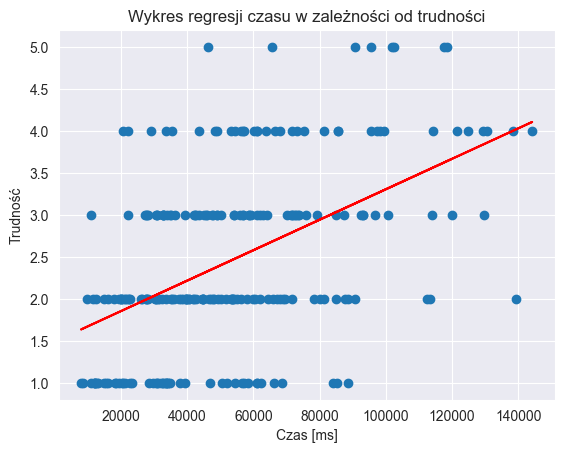

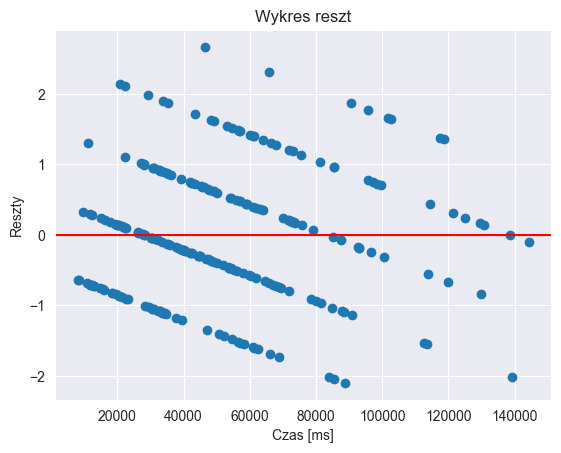

In [130]:
create_plots(df)

b) grafiki A

In [131]:
czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration') and col.endswith('a'):
        czas.append(df_merge[col])
        
trud = []
for col in df_merge.columns.tolist():
    if col.endswith('a_trud'):
        trud.append(df_merge[col])

df = prepate_set(czas, trud)
df.tail()

,trudnosc,czas
115,2,42131
116,3,27199
117,2,19382
118,2,49298
119,2,67997


In [132]:
is_gaussian(df['czas'], ALPHA)

Stats: 0.9633676409721375
P-value: 0.0023812607396394014
Rozkład jest różny od normalnego.


In [133]:
kruskal_wallis(df, ALPHA)

H: 28.581302901540827
--------------------------------------------------------
p-value:  9.507687981637712e-06
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
--------------------------------------------------------


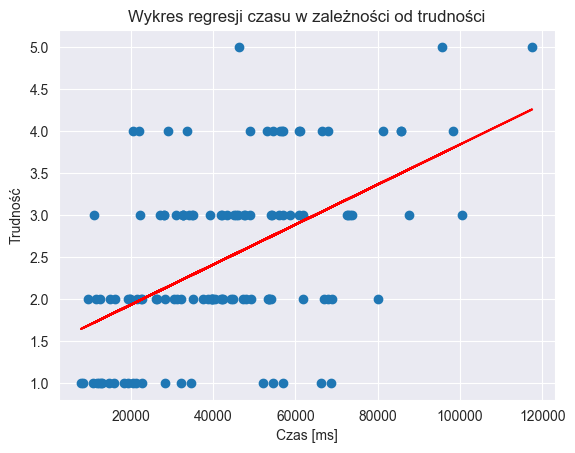

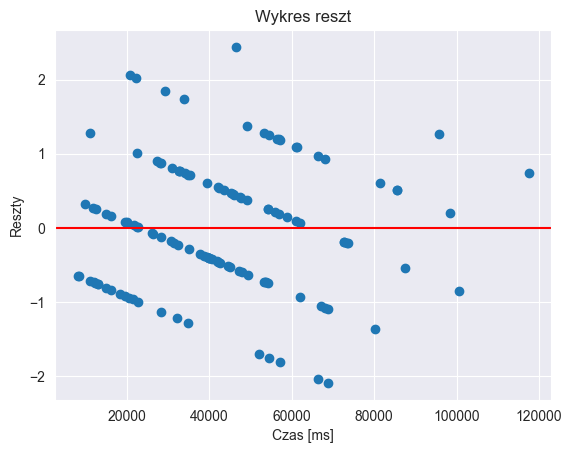

In [134]:
create_plots(df)

c) grafiki B

In [135]:
czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration') and col.endswith('b'):
        czas.append(df_merge[col])
        
trud = []
for col in df_merge.columns.tolist():
    if col.endswith('b_trud'):
        trud.append(df_merge[col])

df = prepate_set(czas, trud)
df.tail()

,trudnosc,czas
115,2,55214
116,3,113828
117,3,93112
118,2,35898
119,3,119944


In [136]:
is_gaussian(df['czas'], ALPHA)

Stats: 0.9449341893196106
P-value: 9.35385687625967e-05
Rozkład jest różny od normalnego.


In [137]:
kruskal_wallis(df, ALPHA)

H: 36.092067445706306
--------------------------------------------------------
p-value:  2.7702035589249966e-07
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
--------------------------------------------------------


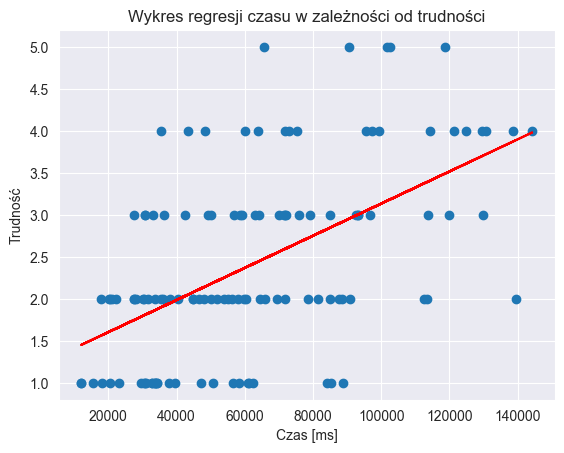

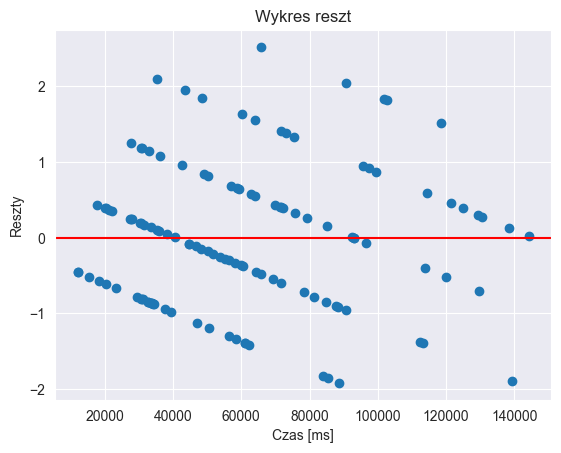

In [138]:
create_plots(df)

d) grafiki 1,2,3

-> 1

In [139]:
czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration_1'):
        czas.append(df_merge[col])

trud = []
for col in df_merge.columns.tolist():
    if col.startswith('1') and col.endswith('_trud'):
        trud.append(df_merge[col])
        
df = prepate_set(czas, trud)
df.tail()

,trudnosc,czas
75,1,58347
76,2,64430
77,1,32732
78,1,47031
79,3,96628


In [140]:
is_gaussian(df['czas'], ALPHA)

Stats: 0.9487757682800293
P-value: 0.002935204654932022
Rozkład jest różny od normalnego.


In [141]:
kruskal_wallis(df, ALPHA)

H: 9.535284591951267
--------------------------------------------------------
p-value:  0.0490272548941204
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
--------------------------------------------------------


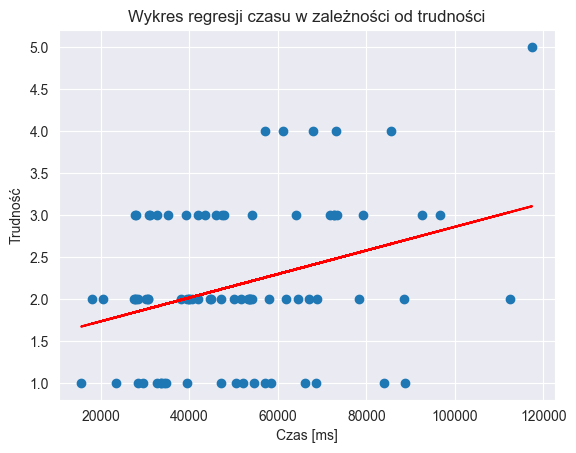

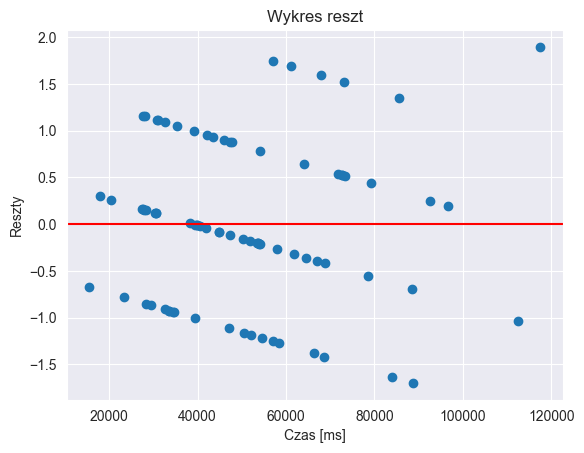

In [142]:
create_plots(df)

-> 2

In [143]:
czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration_2'):
        czas.append(df_merge[col])

trud = []
for col in df_merge.columns.tolist():
    if col.startswith('2') and col.endswith('_trud'):
        trud.append(df_merge[col])
        
df = prepate_set(czas, trud)
df.tail()

,trudnosc,czas
75,1,34215
76,2,69413
77,1,60964
78,2,31582
79,2,113378


In [144]:
is_gaussian(df['czas'], ALPHA)

Stats: 0.9244557619094849
P-value: 0.00015536413411609828
Rozkład jest różny od normalnego.


In [145]:
kruskal_wallis(df, ALPHA)

H: 21.18016593933101
--------------------------------------------------------
p-value:  0.00029165669378083443
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
--------------------------------------------------------


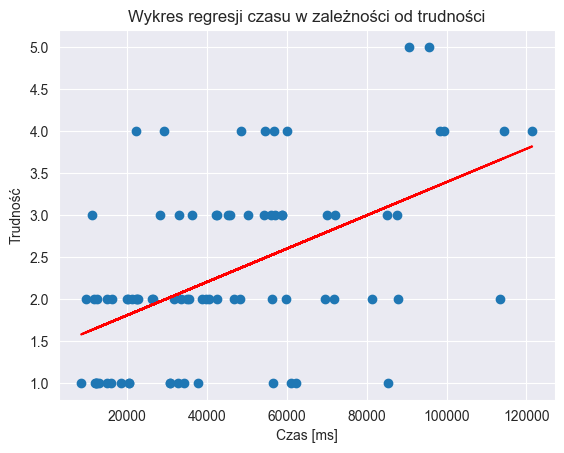

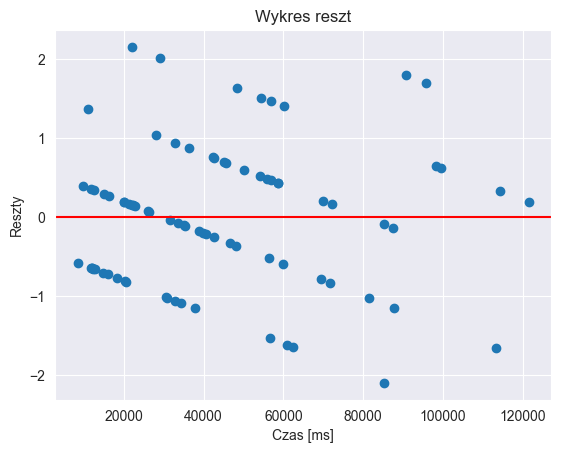

In [146]:
create_plots(df)

-> 3

In [147]:
czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration_3'):
        czas.append(df_merge[col])

trud = []
for col in df_merge.columns.tolist():
    if col.startswith('3') and col.endswith('_trud'):
        trud.append(df_merge[col])
    
df = prepate_set(czas, trud)
df.tail()

,trudnosc,czas
75,2,55214
76,3,113828
77,3,93112
78,2,35898
79,3,119944


In [148]:
is_gaussian(df['czas'], ALPHA)

Stats: 0.9390817880630493
P-value: 0.0008601663284935057
Rozkład jest różny od normalnego.


In [149]:
kruskal_wallis(df, ALPHA)

H: 25.490969093397517
--------------------------------------------------------
p-value:  4.007434623559969e-05
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
--------------------------------------------------------


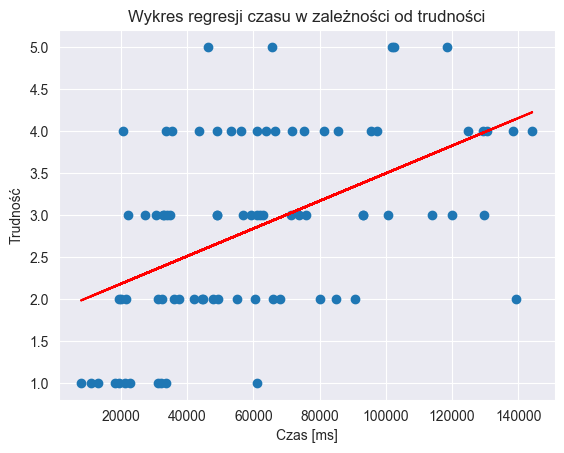

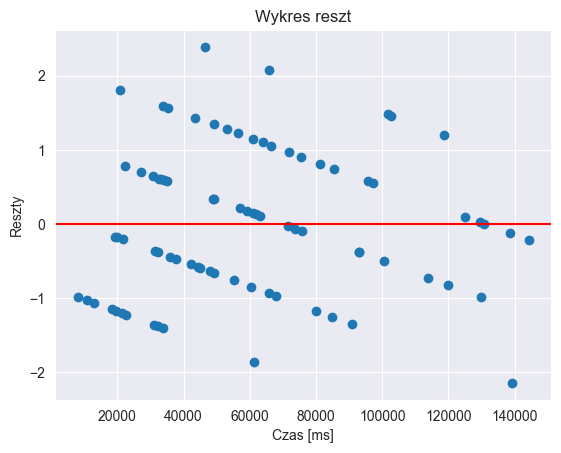

In [150]:
create_plots(df)

e) zadania 1a, 1b, 2a, 2b, 3a, 3b

In [151]:
df1a = pd.DataFrame({'czas': df_merge['Duration_1a'], 'trudnosc': df_merge['1a_trud']})
df2a = pd.DataFrame({'czas': df_merge['Duration_2a'], 'trudnosc': df_merge['2a_trud']})
df3a = pd.DataFrame({'czas': df_merge['Duration_3a'], 'trudnosc': df_merge['3a_trud']})

df1b = pd.DataFrame({'czas': df_merge['Duration_1b'],'trudnosc': df_merge['1b_trud']})
df2b = pd.DataFrame({'czas': df_merge['Duration_2b'], 'trudnosc': df_merge['2b_trud']})
df3b = pd.DataFrame({'czas': df_merge['Duration_3b'], 'trudnosc': df_merge['3b_trud']})

dfs = [df1a, df1b, df2a, df2b, df3a, df3b]

In [152]:
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(f"{i+1}:")
    is_gaussian(df['czas'], ALPHA)

-------------------------------------
1:
Stats: 0.9164128303527832
P-value: 0.0059500802308321
Rozkład jest różny od normalnego.
-------------------------------------
2:
Stats: 0.9273679256439209
P-value: 0.013227981515228748
Rozkład jest różny od normalnego.
-------------------------------------
3:
Stats: 0.8683959245681763
P-value: 0.000259928114246577
Rozkład jest różny od normalnego.
-------------------------------------
4:
Stats: 0.9549580812454224
P-value: 0.11238806694746017
Dane mają rozkład normalny.
-------------------------------------
5:
Stats: 0.9572257995605469
P-value: 0.13453315198421478
Dane mają rozkład normalny.
-------------------------------------
6:
Stats: 0.9545148611068726
P-value: 0.10850247740745544
Dane mają rozkład normalny.


In [153]:
no_gauss = [df1a, df1b, df2a]
gauss = [df2b, df3a, df3b]

In [154]:
for i, df in enumerate(gauss):
    print('-------------------------------------')
    print(f"{i+1}:")
    homogeneity_var(df, ALPHA)

-------------------------------------
1:
0.9731271430788316
--------------------------------------------------------
p-value:  0.43461095471391953
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
-------------------------------------
2:
1.5301247458236718
--------------------------------------------------------
p-value:  0.21480514313179033
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
-------------------------------------
3:
1.2429233770757295
--------------------------------------------------------
p-value:  0.3108074321522639
Brak podstaw do odrzucenia H0.
--------------------------------------------------------


In [155]:
for i, df in enumerate(gauss):
    print('-------------------------------------')
    print(f"{i+1}:")
    anova(df, ALPHA)

-------------------------------------
1:
F-value: 3.9245563400409433
--------------------------------------------------------
p-value:  0.009800883434643113
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
--------------------------------------------------------
-------------------------------------
2:
F-value: 4.248565091415587
--------------------------------------------------------
p-value:  0.006596764886223408
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
--------------------------------------------------------
-------------------------------------
3:
F-value: 2.873389780520085
--------------------------------------------------------
p-value:  0.03700231037793992
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
--------------------------------------------------------


In [156]:
for i, df in enumerate(no_gauss):
    print('-------------------------------------')
    print(f"{i+1}:")
    kruskal_wallis(df, ALPHA)

-------------------------------------
1:
H: 8.033623693379809
--------------------------------------------------------
p-value:  0.09035425169108957
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
-------------------------------------
2:
H: 4.0427062026548555
--------------------------------------------------------
p-value:  0.25688940452274556
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
-------------------------------------
3:
H: 20.1917516629712
--------------------------------------------------------
p-value:  0.0004576973780198644
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
--------------------------------------------------------


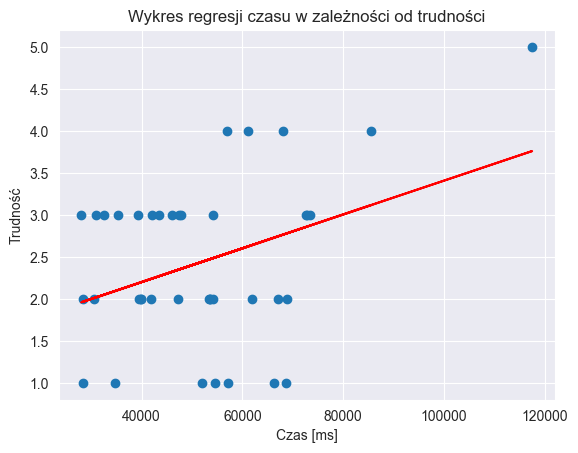

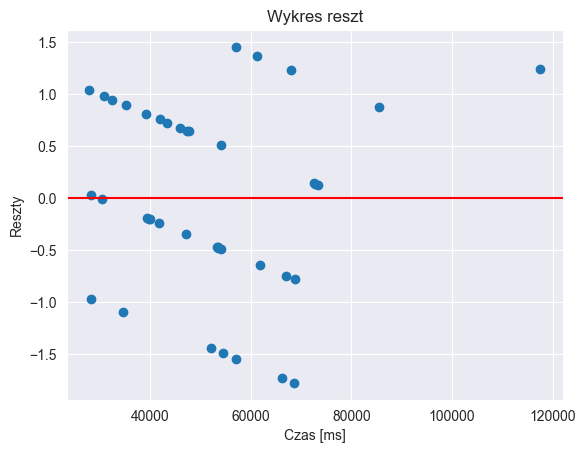

In [157]:
create_plots(df1a)

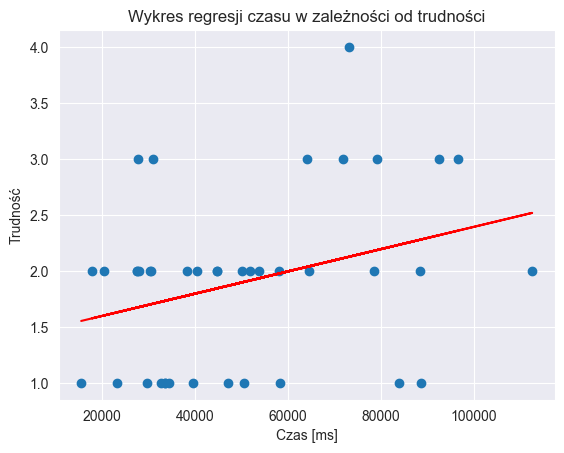

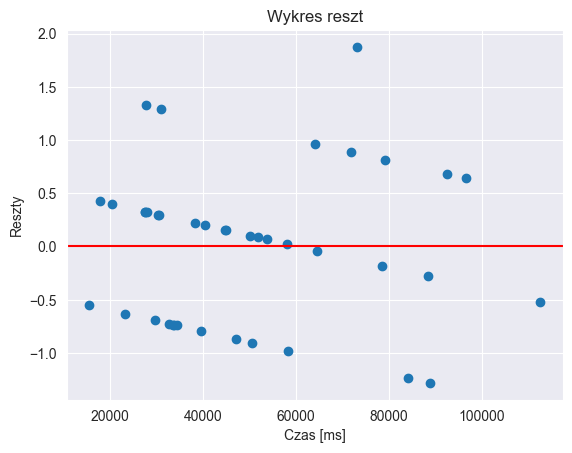

In [158]:
create_plots(df1b)

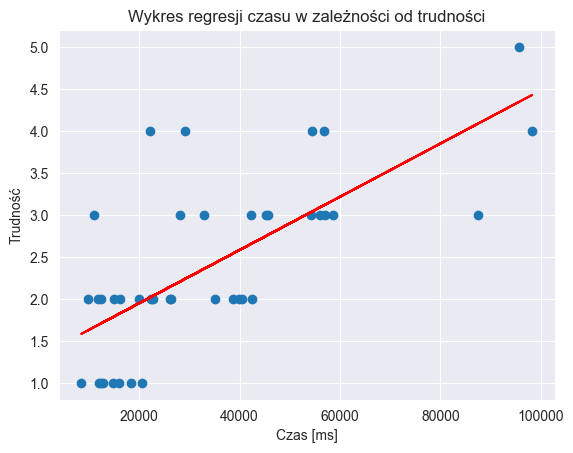

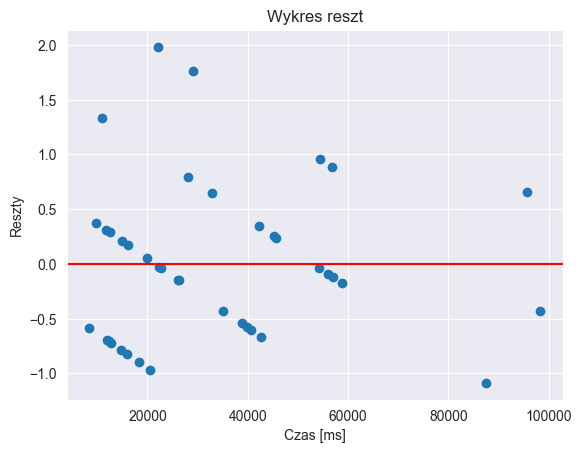

In [159]:
create_plots(df2a)

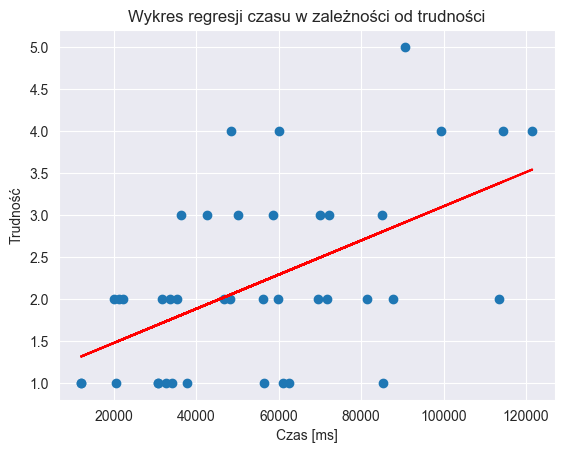

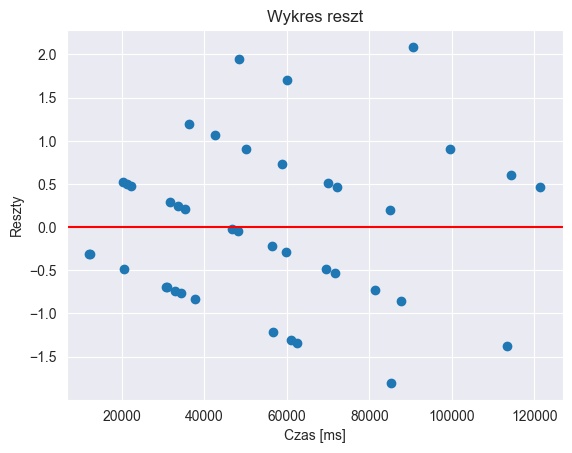

In [160]:
create_plots(df2b)

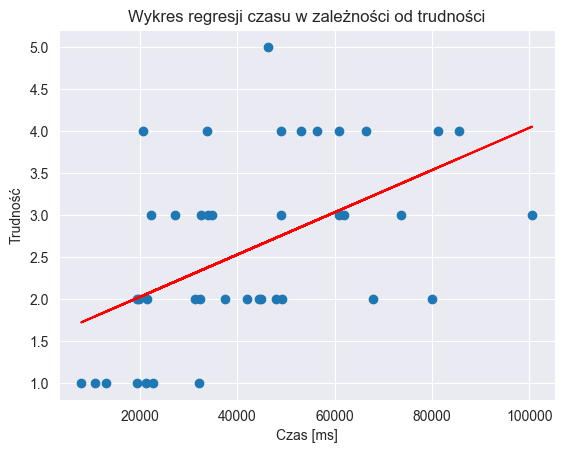

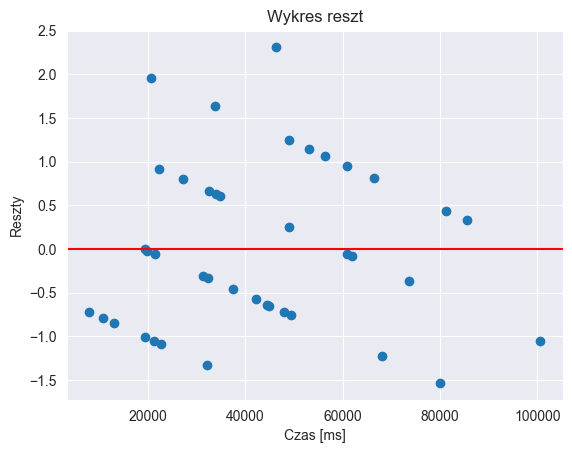

In [161]:
create_plots(df3a)

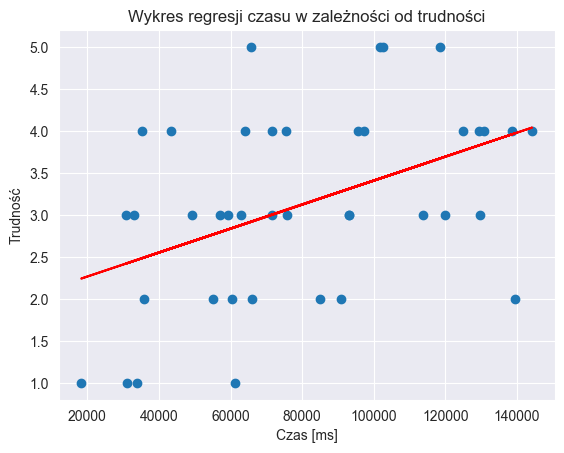

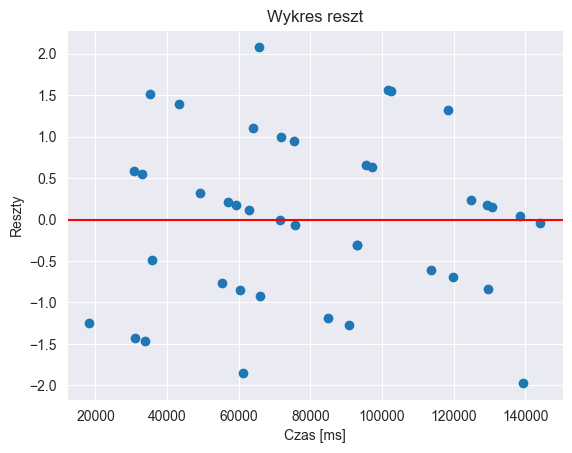

In [162]:
create_plots(df3b)

### Podsumowanie:
Istnieje istotna statystycznie zależność między czasem odpowiedzi a trudnością zadania dla:
- wszystkich grafik
- grafik A
- grafik B
- grafik 1,2,3
- grafik 1a,1b,2a,3b

(wszystkie poza 2b i 3a)

Czas odpowiedzi wzrastał wraz ze wzrostem oceny trudności (dla wszystkich analizowanych przypadków poza 2b i 3a ten wzrost był istotny statystycznie).
